# Step 3: Feature engineering & Model

---

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Đọc dữ liệu đã tiền xử lý từ file

In [128]:
data = pd.read_csv('weatherHCM_preprocessed.csv', sep='\t')
data.head(10)

,Date,Time,Weather,Temp,Feels,Gust,Rain,Humidity,Cloud,Pressure,Vis,Wind Speed,Wind Direction
0,"Thu 01, Jan 2009",00:00,Mist,23.0,26.0,15.0,0.0,0.95,1.00,1010.0,Poor,9.0,NNW
1,"Thu 01, Jan 2009",03:00,Rain,23.0,26.0,13.0,0.4,0.95,0.84,1010.0,Poor,9.0,NNW
2,"Thu 01, Jan 2009",06:00,Mist,23.0,26.0,8.0,0.0,0.95,1.00,1011.0,Poor,6.0,N
3,"Thu 01, Jan 2009",09:00,Cloudy,27.0,31.0,7.0,0.1,0.83,0.64,1011.0,Excellent,6.0,NNE
4,"Thu 01, Jan 2009",12:00,Cloudy,28.0,34.0,4.0,0.0,0.76,0.62,1010.0,Excellent,3.0,NE
5,"Thu 01, Jan 2009",15:00,Rain,27.0,32.0,4.0,2.9,0.83,0.74,1009.0,Good,3.0,NNE
6,"Thu 01, Jan 2009",18:00,Cloudy,24.0,27.0,14.0,0.0,0.91,0.73,1010.0,Excellent,7.0,NW
7,"Thu 01, Jan 2009",21:00,Rain,23.0,26.0,18.0,1.6,0.91,0.32,1012.0,Excellent,10.0,NNE
8,"Fri 02, Jan 2009",00:00,Cloudy,23.0,26.0,14.0,0.0,0.91,0.30,1011.0,Excellent,8.0,N
9,"Fri 02, Jan 2009",03:00,Cloudy,23.0,26.0,16.0,0.0,0.91,0.72,1010.0,Excellent,9.0,N


### Feature Engineering

Dùng thuộc tính của 3 khoảng thời gian trước để dự đoán giá trị Temperature ở thời điểm tiếp theo

In [129]:
#https://stackabuse.com/using-machine-learning-to-predict-the-weather-part-1/
def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements
    
for feature in data.columns:
    if feature != 'Time' and feature != 'Date':
        for N in range(1, 4):
            derive_nth_day_feature(data, feature, N)
            
data.drop(columns=['Date', 'Weather', 'Feels', 'Gust', 'Rain', 'Humidity', 'Cloud', 'Pressure', 'Wind Speed', 'Wind Direction', 'Vis'], inplace=True)
data = data[3:]
data.reset_index(drop=True, inplace=True)
            
data.head()

,Time,Temp,Weather_1,Weather_2,Weather_3,Temp_1,Temp_2,Temp_3,Feels_1,Feels_2,...,Pressure_3,Vis_1,Vis_2,Vis_3,Wind Speed_1,Wind Speed_2,Wind Speed_3,Wind Direction_1,Wind Direction_2,Wind Direction_3
0,09:00,27.0,Mist,Rain,Mist,23.0,23.0,23.0,26.0,26.0,...,1010.0,Poor,Poor,Poor,6.0,9.0,9.0,N,NNW,NNW
1,12:00,28.0,Cloudy,Mist,Rain,27.0,23.0,23.0,31.0,26.0,...,1010.0,Excellent,Poor,Poor,6.0,6.0,9.0,NNE,N,NNW
2,15:00,27.0,Cloudy,Cloudy,Mist,28.0,27.0,23.0,34.0,31.0,...,1011.0,Excellent,Excellent,Poor,3.0,6.0,6.0,NE,NNE,N
3,18:00,24.0,Rain,Cloudy,Cloudy,27.0,28.0,27.0,32.0,34.0,...,1011.0,Good,Excellent,Excellent,3.0,3.0,6.0,NNE,NE,NNE
4,21:00,23.0,Cloudy,Rain,Cloudy,24.0,27.0,28.0,27.0,32.0,...,1010.0,Excellent,Good,Excellent,7.0,3.0,3.0,NW,NNE,NE


**Tính độ tương quan giữa các thuộc tính với Temp**

In [117]:
corr = data.corr()[['Temp']].sort_values('Temp')
corr

,Temp
Humidity_1,-0.595621
Temp_3,-0.229862
Gust_2,-0.213911
Feels_3,-0.211747
Gust_3,-0.169267
Humidity_2,-0.155839
Cloud_2,-0.148589
Rain_3,-0.140185
Gust_1,-0.133028
Cloud_1,-0.124421


Bỏ các cột có |correlation| < 0.5

In [118]:
data.drop(columns=[col for col in corr.index if abs(corr['Temp'].loc[col]) < 0.5], inplace=True)

Bỏ các cột không cần thiết cho việc dự đoán

In [119]:
data.drop(columns=['Wind Direction_1', 'Wind Direction_2', 'Wind Direction_3', 'Vis_1', 'Vis_2', 'Vis_3'], inplace=True)
data.head()

,Time,Temp,Weather_1,Weather_2,Weather_3,Temp_1,Feels_1,Humidity_1
0,09:00,27.0,Mist,Rain,Mist,23.0,26.0,0.95
1,12:00,28.0,Cloudy,Mist,Rain,27.0,31.0,0.83
2,15:00,27.0,Cloudy,Cloudy,Mist,28.0,34.0,0.76
3,18:00,24.0,Rain,Cloudy,Cloudy,27.0,32.0,0.83
4,21:00,23.0,Cloudy,Rain,Cloudy,24.0,27.0,0.91


**Encoding categorical values**

In [120]:
# one-hot encoding
cols_object = ['Time', 'Weather_1', 'Weather_2', 'Weather_3']
for col in cols_object:
    dummies = pd.get_dummies(data[col], prefix=col)
    data.drop(columns=[col], inplace=True)
    data = pd.concat([data, dummies], axis=1)
    
data.head()

,Temp,Temp_1,Feels_1,Humidity_1,Time_00:00,Time_03:00,Time_06:00,Time_09:00,Time_12:00,Time_15:00,...,Weather_2_Mist,Weather_2_Overcast,Weather_2_Rain,Weather_2_Sunny,Weather_3_Clear,Weather_3_Cloudy,Weather_3_Mist,Weather_3_Overcast,Weather_3_Rain,Weather_3_Sunny
0,27.0,23.0,26.0,0.95,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1,28.0,27.0,31.0,0.83,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,27.0,28.0,34.0,0.76,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,24.0,27.0,32.0,0.83,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,23.0,24.0,27.0,0.91,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


### Model

**Chuẩn bị dữ liệu**

In [121]:
X = data.drop(columns=['Temp'])
y = data['Temp']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.to_numpy().reshape((-1, 1)))

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

**Linear Regression**

In [123]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [124]:
y_pred = reg.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print(f'Độ lỗi trên tập train: {mse}')

Độ lỗi trên tập train: 0.006907844996619176


In [125]:
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Độ lỗi trên tập test: {mse}')

Độ lỗi trên tập test: 0.014984117619952062


In [126]:
y_pred = reg.predict(X_test[-100:])
y_pred = scaler.inverse_transform(y_pred)

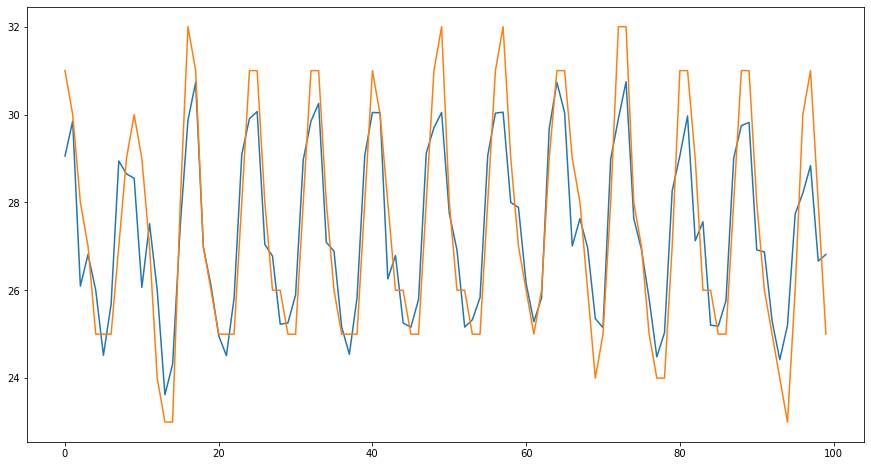

In [127]:
plt.figure(figsize=(15, 8))
plt.plot(y_pred)
plt.plot(data['Temp'][-100:].to_numpy())